## A2C模型
演员-评论员算法是一种结合策略梯度和时序差分学习的强化学习方法，其中，演员是指策略函数 ，即学习一个策略以得到尽可能高的回报。评论员是指价值函数，对当前策略的值函数进行估计，即评估演员的好坏。借助于价值函数，演员-评论员算法可以进行单步参数更新，不需要等到回合结束才进行更新。在演员-评论员算法里面，最知名的算法就是异步优势演员-评论员算法。如果去掉异步，则为优势演员-评论员（advantage actor-critic，A2C）算法。A2C算法又被译作优势演员-评论员算法。如果加了异步，变成异步优势演员-评论员算法。优势函数的估计仍然可以使用时序差分的方法。

注意A2C是一个同策略的算法，因此不能像在DQN中那样构建一个回放池，随后从回放池中拿出一些transition样本来进行训练，必须使用当前策略采样得到一个批次的经验之后，用这个批次的数据对当前的策略进行更新，随后再采样下一个批次，采样过程是可以在多个环境中同时并行执行的。


## 1.1 定义模型
评论员模型是一个简单的MLP，输出一个标量，表示状态的好坏，或者说动作的好坏的平均值。演员则是输出执行各个动作的概率，并将这个概率通过Categorical类进行封装，这个类提供了一个可微分的 log_prob 计算方法。在采样得到动作后，log_prob可以根据选择的动作计算出这个动作的对数概率，而这个对数概率与计算图相连，是有梯度的，可以通过反向传播来进行优化，从而实现“好的动作提高概率，不好的动作降低概率”的目标。对评论员来说，希望评论员的评论越准越好，评论员相当于一个回归模型，用于预测状态的价值，因此使用均方差损失让评论员的预测更准确，更接近“真实”的回报。熵损失则是希望模型能更加具有探索性。

In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value



## 1.2 创建环境和训练

这里为了简化，仅创建一个环境并采样，

In [7]:
def test_env(env, model, cfg, vis=False):
    '''
    测试函数，适配新版Gymnasium API
    '''
    # 使用 seed 重置环境以保证可复现性
    state, info = env.reset(seed=cfg.seed + 1) # 使用不同的种子以区别于训练
        
    done = False
    total_reward = 0
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(cfg.device)
        dist, _ = model(state_tensor)
        action = dist.sample().cpu().numpy()[0]
        
        # 使用新版API
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated # 回合结束条件
        
        state = next_state
        total_reward += reward
        
    return total_reward

def compute_returns(next_value, rewards, masks, gamma=0.99):
    '''
    计算n-step的折扣回报
    '''
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


def train(cfg):
    print('Start training!')
    print(f'Env: {cfg.env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}')
    
    # 创建单个环境，适配新版Gymnasium API
    env = gym.make(cfg.env_name) 
    
    n_states  = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    model = ActorCritic(n_states, n_actions, cfg.hidden_dim).to(cfg.device)
    optimizer = optim.Adam(model.parameters())
    
    step_idx = 0
    test_rewards = []
    test_ma_rewards = []
    
    # 初始化状态，使用新API并设置种子
    state, info = env.reset(seed=cfg.seed)
    
    while step_idx < cfg.max_steps:
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0
        # Rollout Trajectory: 在单个环境中采样n_steps
        for _ in range(cfg.n_steps):
            # 将单个状态(numpy array)转换为批次为1的张量
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(cfg.device)
            dist, value = model(state_tensor)
            
            action = dist.sample()
            # 从环境中执行动作，获取新API的返回值
            # 使用 action.item() 获取标量动作
            next_state, reward, terminated, truncated, info = env.step(action.item())
            
            done = terminated or truncated # 判断回合是否结束
            
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()
            
            # 存储数据，并确保它们是具有正确维度的张量
            log_probs.append(log_prob)
            values.append(value)
            # 将标量 reward 转换为 [1, 1] 的张量
            rewards.append(torch.FloatTensor([reward]).unsqueeze(1).to(cfg.device))
            # 将标量 done 转换为 [1, 1] 的张量
            masks.append(torch.FloatTensor([1 - done]).unsqueeze(1).to(cfg.device))
            
            state = next_state
            step_idx += 1
            
            # 如果回合结束，立即重置环境
            if done:
                state, info = env.reset()
            # 定期评估模型
            if step_idx % 200 == 0:
                test_reward = np.mean([test_env(env, model, cfg) for _ in range(10)])
                print(f"Step_idx: {step_idx}, Test Reward: {test_reward:.2f}")
                test_rewards.append(test_reward)
                if test_ma_rewards:
                    test_ma_rewards.append(0.9 * test_ma_rewards[-1] + 0.1 * test_reward)
                else:
                    test_ma_rewards.append(test_reward) 
        
        
        # 计算下一个状态的价值
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(cfg.device)
        _, next_value = model(next_state_tensor)
        
        # 如果最后一个状态是回合结束状态，则next_value应为0
        if done:
            next_value = torch.tensor([[0.0]], device=cfg.device)
        returns = compute_returns(next_value, rewards, masks, cfg.gamma)
        
        # 合并n_steps的数据
        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values)
        
        advantage = returns - values
        
        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        
        # 总损失
        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Finish training！')
    env.close()
    return test_rewards, test_ma_rewards

In [12]:
import matplotlib.pyplot as plt
import seaborn 
# 绘图函数 绘制测试奖励
def plot_rewards(rewards, ma_rewards, cfg, tag='train'):
    seaborn.set()
    plt.figure()
    plt.title("Learning Curve on {} of {} for {}".format(
        cfg.device, cfg.algo_name, cfg.env_name))
    # rewards的长度与评估次数有关，横坐标应为评估的“步”
    eval_steps = np.arange(len(rewards)) * 200 # 假设每200步评估一次
    plt.xlabel('Training Steps')
    plt.ylabel('Reward')
    plt.plot(eval_steps, rewards, label='Reward')
    plt.plot(eval_steps, ma_rewards, label='MA Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

## 2 定义训练参数配置

Start training!
Env: CartPole-v1, Algorithm: A2C, Device: cuda
Step_idx: 200, Test Reward: 27.00


/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Step_idx: 400, Test Reward: 11.00
Step_idx: 600, Test Reward: 13.30
Step_idx: 800, Test Reward: 10.70
Step_idx: 1000, Test Reward: 10.10
Step_idx: 1200, Test Reward: 9.60
Step_idx: 1400, Test Reward: 11.80
Step_idx: 1600, Test Reward: 13.40
Step_idx: 1800, Test Reward: 21.80
Step_idx: 2000, Test Reward: 26.00
Step_idx: 2200, Test Reward: 43.00
Step_idx: 2400, Test Reward: 52.60
Step_idx: 2600, Test Reward: 75.50
Step_idx: 2800, Test Reward: 93.00
Step_idx: 3000, Test Reward: 57.00
Step_idx: 3200, Test Reward: 96.20
Step_idx: 3400, Test Reward: 75.80
Step_idx: 3600, Test Reward: 40.80
Step_idx: 3800, Test Reward: 39.20
Step_idx: 4000, Test Reward: 43.70
Step_idx: 4200, Test Reward: 93.10
Step_idx: 4400, Test Reward: 117.30
Step_idx: 4600, Test Reward: 158.40
Step_idx: 4800, Test Reward: 87.30
Step_idx: 5000, Test Reward: 71.10
Step_idx: 5200, Test Reward: 49.40
Step_idx: 5400, Test Reward: 102.70
Step_idx: 5600, Test Reward: 205.70
Step_idx: 5800, Test Reward: 201.30
Step_idx: 6000, Tes

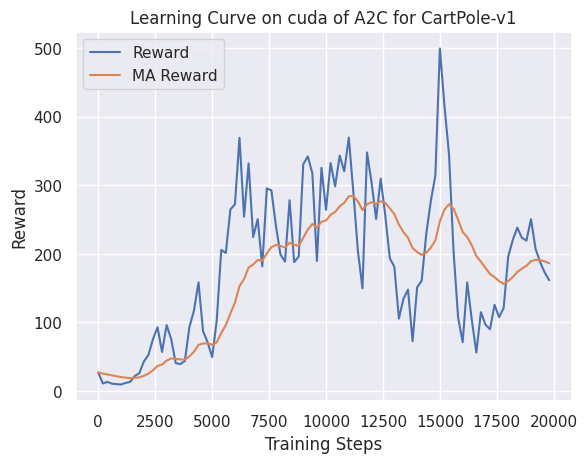

In [13]:
class Config:
    def __init__(self):
        self.algo_name = 'A2C'
        self.env_name = 'CartPole-v1'
        self.max_steps = 20000
        self.n_steps = 5          # Rollout步数
        self.gamma = 0.99
        self.lr = 1e-3
        self.hidden_dim = 256
        self.seed = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()
# 直接调用 train 函数，它内部会创建单个环境
rewards, ma_rewards = train(cfg)
    
# 画出结果
plot_rewards(rewards, ma_rewards, cfg, tag="train")
